In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import re
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import seaborn as sn
!pip install tf-models-official
import tensorflow_hub
from official.nlp.bert import tokenization

In [ ]:
if not os.path.exists('/content/trainingandtestdata.zip'):
  !wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
if not os.path.exists('/content/drive/MyDrive/DL - HW3 Practical/training.1600000.processed.noemoticon.csv'):
  !unzip -q trainingandtestdata.zip -d '/content/drive/MyDrive/DL - HW3 Practical'

In [ ]:
columns = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv('/content/drive/MyDrive/DL - HW3 Practical/training.1600000.processed.noemoticon.csv', names=columns, encoding='latin-1')
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df = df[['sentiment', 'text']]
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
class data_struct():
  def __init__(self, sentiment, text, adjusted_text=None, featured_text=None):
    self.sentiment = sentiment
    self.text = text
    self.adjusted_text = adjusted_text
    self.featured_text = featured_text

In [ ]:
data = []
for index, row in df.iterrows():
  data.append(data_struct(row['sentiment'], row['text']))

In [ ]:
output_indices = []
for index, tweet in enumerate(data):
  text = tweet.text
  text = text.strip().lower()
  temp = re.sub('http:\/\/[^ ]*|https:\/\/[^ ]*|www\.[^ ]*', '', text)
  if text == temp:
    temp = re.sub('#[^\s]+', '', temp)
    temp = re.sub('@[^\s]+', '', temp)
    temp = re.sub('(^| ).($| )', ' ', temp)
    temp = re.sub('(^| )d+($| )', ' ', temp)
    temp = re.sub('(^| )(\'s)($| )', ' ', temp)
    temp = re.sub('(\'s\s)', '', temp)
    temp = re.sub('[^\w\s]', '', temp)
    tweet.adjusted_text = temp.strip().split()
    output_indices.append(index)
cleaned_data = [data[i] for i in output_indices]

In [ ]:
maximum_length = 0
for tweet in cleaned_data:
  temp = len(tweet.adjusted_text)
  if maximum_length < temp:
    maximum_length = temp
print(maximum_length)

40


In [ ]:
word2idx = {}
word2idx['<PAD>'] = 0
length = 1
for tweet in cleaned_data:
  featured_text = np.zeros((1, maximum_length))
  temp = maximum_length-len(tweet.adjusted_text)
  for index, word in enumerate(tweet.adjusted_text):
    if word in word2idx.keys():
      featured_text[0][temp+index] = word2idx[word]
    else:
      word2idx[word] = length
      featured_text[0][temp+index] = length
      length = length + 1
  tweet.featured_text = featured_text

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/cleaned_data.pkl', 'wb') as f:
  pickle.dump(cleaned_data, f)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/cleaned_data.pkl', 'rb') as f:
  cleaned_data = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/word2idx.pkl', 'wb') as f:
  pickle.dump(word2idx, f)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/word2idx.pkl', 'rb') as f:
  word2idx = pickle.load(f)

In [ ]:
data_X = np.zeros((len(cleaned_data), maximum_length))
data_Y = np.zeros((len(cleaned_data), 1))
for index, tweet in enumerate(cleaned_data):
  data_X[index, :] = tweet.featured_text
  data_Y[index, 0] = int(tweet.sentiment/4)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/data_X.pkl', 'wb') as f:
  pickle.dump(data_X, f)
with open('/content/drive/MyDrive/DL - HW3 Practical/data_Y.pkl', 'wb') as f:
  pickle.dump(data_Y, f)

In [3]:
with open('/content/drive/MyDrive/DL - HW3 Practical/data_X.pkl', 'rb') as f:
  data_X = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/data_Y.pkl', 'rb') as f:
  data_Y = pickle.load(f)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2022-01-14 15:05:35--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2022-01-14 15:05:35--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2022-01-14 15:05:35--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [ ]:
!unzip glove.42B.300d.zip

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
def load_glove_model(filename):
  glove_model = {}
  with open(filename,'r', encoding='utf-8') as file:
    lines = file.readlines()
  for line in lines:
    line = line.split()
    word = line[0]
    embedding = np.array(line[1:], dtype=np.float64)
    glove_model[word] = embedding
  return glove_model

In [ ]:
glove = load_glove_model('/content/glove.42B.300d.txt')

In [ ]:
mean = np.mean(np.array(list(glove.values())), axis=0)
embedding_matrix = np.zeros((len(word2idx), 300))
for index, word in enumerate(word2idx.keys()):
  if not index == 0:
    if word in glove.keys():
      embedding_matrix[index, :] = glove[word]
    else:
      embedding_matrix[index, :] = mean

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/embedding_matrix.pkl', 'wb') as f:
  pickle.dump(embedding_matrix, f)

In [4]:
with open('/content/drive/MyDrive/DL - HW3 Practical/embedding_matrix.pkl', 'rb') as f:
  embedding_matrix = pickle.load(f)

In [ ]:
random_number = np.random.randint(1e9)
np.random.seed(random_number)
permutation = np.random.choice(range(data_X.shape[0]), data_X.shape[0], False)
data_X = data_X[permutation]
data_Y = data_Y[permutation]
X_train = data_X[0:int(8/10*len(data_X)), :]
print('X_train =', X_train.shape)
Y_train = data_Y[0:int(8/10*len(data_X)), :]
print('Y_train =', Y_train.shape)
X_validation = data_X[int(8/10*len(data_X)):int(9/10*len(data_X)), :]
print('X_validation =', X_validation.shape)
Y_validation = data_Y[int(8/10*len(data_X)):int(9/10*len(data_X)), :]
print('Y_validation =', Y_validation.shape)
X_test = data_X[int(9/10*len(data_X)):len(data_X), :]
print('X_test =', X_test.shape)
Y_test = data_Y[int(9/10*len(data_X)):len(data_X), :]
print('Y_test =', Y_test.shape)

X_train = (1218732, 40)
Y_train = (1218732, 1)
X_validation = (152342, 40)
Y_validation = (152342, 1)
X_test = (152342, 40)
Y_test = (152342, 1)


In [ ]:
Y_train_one_hot = tf.one_hot(Y_train[:, 0], 2)
print('Y_train_one_hot.shape: ', Y_train_one_hot.shape)
Y_validation_one_hot = tf.one_hot(Y_validation[:, 0], 2)
print('Y_validation_one_hot.shape: ', Y_validation_one_hot.shape)
Y_test_one_hot = tf.one_hot(Y_test[:, 0], 2)
print('Y_test_one_hot.shape: ', Y_test_one_hot.shape)

Y_train_one_hot.shape:  (1218732, 2)
Y_validation_one_hot.shape:  (152342, 2)
Y_test_one_hot.shape:  (152342, 2)


# One-Sided LSTM

In [ ]:
lstm_hidden_layer_size = 150
hidden_layer_size = 50
output_size = 2
batch_size = 1225
number_of_epochs = 4

In [ ]:
model = tf.keras.models.Sequential(name='One_Sided_LSTM')
model.add(tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=data_X.shape[1], trainable=False, name='Embedding'))
model.add(tf.keras.layers.LSTM(lstm_hidden_layer_size, name='LSTM'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation='ReLU', name='FC'))
model.add(tf.keras.layers.Dense(output_size, activation='sigmoid', name='Output'))
print(model.summary())

Model: "One_Sided_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 40, 300)           139187700 
                                                                 
 LSTM (LSTM)                 (None, 150)               270600    
                                                                 
 FC (Dense)                  (None, 50)                7550      
                                                                 
 Output (Dense)              (None, 2)                 102       
                                                                 
Total params: 139,465,952
Trainable params: 278,252
Non-trainable params: 139,187,700
_________________________________________________________________
None


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

In [ ]:
def scheduler(epoch, lr):
  return lr/1.05
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(X_train, Y_train_one_hot, batch_size=batch_size, epochs=number_of_epochs, callbacks=[lr_cb], validation_data=(X_validation, Y_validation_one_hot))

Epoch 1/4
995/995 [==============================] - 34s 33ms/step - loss: 0.4200 - accuracy: 0.8044 - val_loss: 0.3935 - val_accuracy: 0.8205 - lr: 0.0048
Epoch 2/4
995/995 [==============================] - 33s 33ms/step - loss: 0.3766 - accuracy: 0.8296 - val_loss: 0.3828 - val_accuracy: 0.8263 - lr: 0.0045
Epoch 3/4
995/995 [==============================] - 34s 34ms/step - loss: 0.3567 - accuracy: 0.8398 - val_loss: 0.3815 - val_accuracy: 0.8284 - lr: 0.0043
Epoch 4/4
995/995 [==============================] - 34s 34ms/step - loss: 0.3399 - accuracy: 0.8489 - val_loss: 0.3867 - val_accuracy: 0.8262 - lr: 0.0041


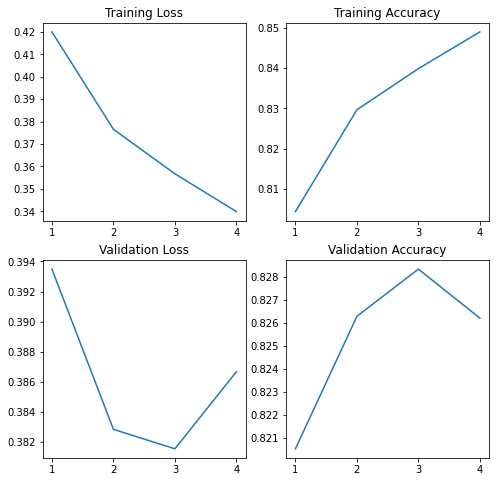

In [ ]:
history = history.history
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, 5), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, 5), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, 5), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, 5), history['val_accuracy'])

4761/4761 [==============================] - 17s 3ms/step - loss: 0.3874 - accuracy: 0.8266
Test Loss =  0.3873851001262665
Test Accuracy =  0.8265547156333923


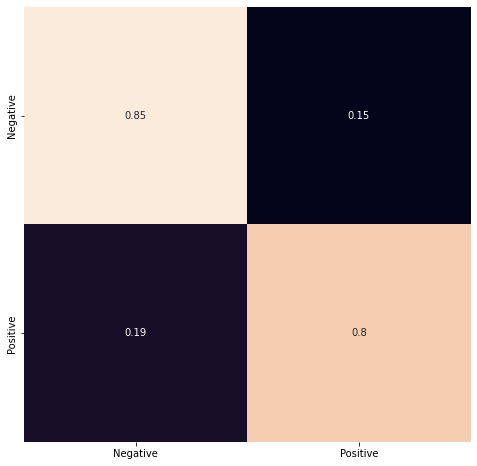

In [ ]:
[test_loss, test_accuracy] = model.evaluate(X_test, Y_test_one_hot)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)
predicted_Y_test = model.predict(X_test)
confusion_matrix = tf.math.confusion_matrix(Y_test, np.argmax(predicted_Y_test, axis=-1), 2).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.figure(figsize=(8, 8))
sn.heatmap(df, annot=True, cbar=False)

# Bidirectional LSTM

In [ ]:
lstm_hidden_layer_size = 150
hidden_layer_size = 50
output_size = 2
batch_size = 1225
number_of_epochs = 4

In [ ]:
model = tf.keras.models.Sequential(name='Bidirectional_LSTM')
model.add(tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=data_X.shape[1], trainable=False, name='Embedding'))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_hidden_layer_size, name='LSTM')))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation='ReLU', name='FC'))
model.add(tf.keras.layers.Dense(output_size, activation='sigmoid', name='Output'))
print(model.summary())

Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 40, 300)           139187700 
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 FC (Dense)                  (None, 50)                15050     
                                                                 
 Output (Dense)              (None, 2)                 102       
                                                                 
Total params: 139,744,052
Trainable params: 556,352
Non-trainable params: 139,187,700
_________________________________________________________________
None


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

In [ ]:
def scheduler(epoch, lr):
  return lr/1.05
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(X_train, Y_train_one_hot, batch_size=batch_size, epochs=number_of_epochs, callbacks=[lr_cb], validation_data=(X_validation, Y_validation_one_hot))

Epoch 1/4
995/995 [==============================] - 69s 67ms/step - loss: 0.4208 - accuracy: 0.8041 - val_loss: 0.3932 - val_accuracy: 0.8195 - lr: 0.0048
Epoch 2/4
995/995 [==============================] - 67s 67ms/step - loss: 0.3766 - accuracy: 0.8296 - val_loss: 0.3821 - val_accuracy: 0.8265 - lr: 0.0045
Epoch 3/4
995/995 [==============================] - 67s 68ms/step - loss: 0.3570 - accuracy: 0.8397 - val_loss: 0.3853 - val_accuracy: 0.8263 - lr: 0.0043
Epoch 4/4
995/995 [==============================] - 68s 68ms/step - loss: 0.3406 - accuracy: 0.8482 - val_loss: 0.3839 - val_accuracy: 0.8278 - lr: 0.0041


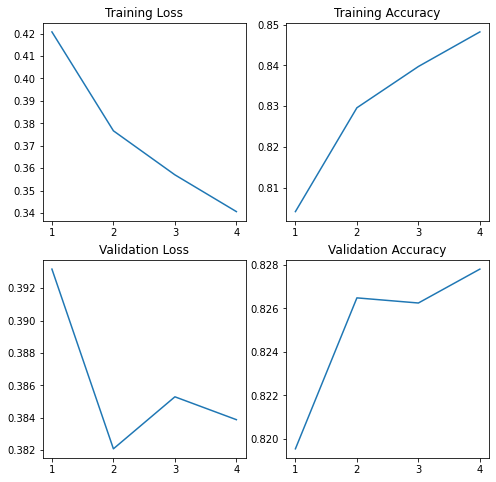

In [ ]:
history = history.history
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, 5), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, 5), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, 5), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, 5), history['val_accuracy'])

4761/4761 [==============================] - 21s 4ms/step - loss: 0.3848 - accuracy: 0.8282
Test Loss =  0.3848261833190918
Test Accuracy =  0.8281957507133484


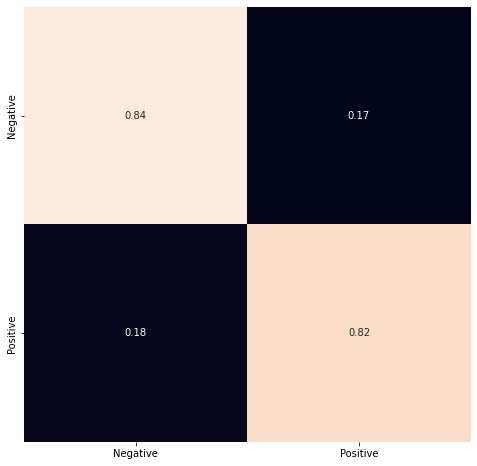

In [ ]:
[test_loss, test_accuracy] = model.evaluate(X_test, Y_test_one_hot)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)
predicted_Y_test = model.predict(X_test)
confusion_matrix = tf.math.confusion_matrix(Y_test, np.argmax(predicted_Y_test, axis=-1), 2).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.figure(figsize=(8, 8))
sn.heatmap(df, annot=True, cbar=False)

# Comparison between One-Sided LSTM and Bidirectional LSTM

The Bidirectional LSTM is slightly better than the One-Sided LSTM, But its trainging time is more and its convergence speed is less (Actually, It probably depends on the initial state of networks).

# Pyramidal One-Sided LSTM

In [ ]:
maximum_length = data_X.shape[1]
length = int(np.power(2, np.ceil(np.log(maximum_length)/np.log(2))))
if length > maximum_length:
  adjusted_data_X = np.concatenate((np.zeros((data_X.shape[0], length-maximum_length)).T, data_X.T)).T
adjusted_data_Y = data_Y.copy()

In [ ]:
random_number = np.random.randint(1e9)
np.random.seed(random_number)
permutation = np.random.choice(range(adjusted_data_X.shape[0]), adjusted_data_X.shape[0], False)
adjusted_data_X = adjusted_data_X[permutation]
adjusted_data_Y = adjusted_data_Y[permutation]
adjusted_X_train = adjusted_data_X[0:int(8/10*len(adjusted_data_X)), :]
print('adjusted_X_train =', adjusted_X_train.shape)
adjusted_Y_train = adjusted_data_Y[0:int(8/10*len(adjusted_data_X)), :]
print('adjusted_Y_train =', adjusted_Y_train.shape)
adjusted_X_validation = adjusted_data_X[int(8/10*len(adjusted_data_X)):int(9/10*len(adjusted_data_X)), :]
print('adjusted_X_validation =', adjusted_X_validation.shape)
adjusted_Y_validation = adjusted_data_Y[int(8/10*len(adjusted_data_X)):int(9/10*len(adjusted_data_X)), :]
print('adjusted_Y_validation =', adjusted_Y_validation.shape)
adjusted_X_test = adjusted_data_X[int(9/10*len(adjusted_data_X)):len(adjusted_data_X), :]
print('adjusted_X_test =', adjusted_X_test.shape)
adjusted_Y_test = adjusted_data_Y[int(9/10*len(adjusted_data_X)):len(adjusted_data_X), :]
print('adjusted_Y_test =', adjusted_Y_test.shape)

adjusted_X_train = (1218732, 64)
adjusted_Y_train = (1218732, 1)
adjusted_X_validation = (152342, 64)
adjusted_Y_validation = (152342, 1)
adjusted_X_test = (152342, 64)
adjusted_Y_test = (152342, 1)


In [ ]:
adjusted_Y_train_one_hot = tf.one_hot(adjusted_Y_train[:, 0], 2)
print('adjusted_Y_train_one_hot.shape: ', adjusted_Y_train_one_hot.shape)
adjusted_Y_validation_one_hot = tf.one_hot(adjusted_Y_validation[:, 0], 2)
print('adjusted_Y_validation_one_hot.shape: ', adjusted_Y_validation_one_hot.shape)
adjusted_Y_test_one_hot = tf.one_hot(adjusted_Y_test[:, 0], 2)
print('adjusted_Y_test_one_hot.shape: ', adjusted_Y_test_one_hot.shape)

adjusted_Y_train_one_hot.shape:  (1218732, 2)
adjusted_Y_validation_one_hot.shape:  (152342, 2)
adjusted_Y_test_one_hot.shape:  (152342, 2)


In [ ]:
input_size = length
lstm_1_hidden_layer_size = 64
lstm_2_hidden_layer_size = 128
lstm_3_hidden_layer_size = 256
lstm_4_hidden_layer_size = 512
hidden_layer_size = 50
output_size = 2
batch_size = 1225
number_of_epochs = 4

In [ ]:
input = tf.keras.layers.Input(shape=input_size, name='Input')
input_1 = tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=length, trainable=False, name='Embedding')(input)
lstm_1 = tf.keras.layers.LSTM(lstm_1_hidden_layer_size, return_sequences=True, name='LSTM_1')(input_1)
input_2 = tf.concat([tf.gather(lstm_1, range(0, length, 2), axis=1), tf.gather(lstm_1, range(1, length+1, 2), axis=1)], axis=2)
lstm_2 = tf.keras.layers.LSTM(lstm_2_hidden_layer_size, return_sequences=True, name='LSTM_2')(input_2)
input_3 = tf.concat([tf.gather(lstm_2, range(0, int(length/2), 2), axis=1), tf.gather(lstm_2, range(1, int(length/2)+1, 2), axis=1)], axis=2)
lstm_3 = tf.keras.layers.LSTM(lstm_3_hidden_layer_size, return_sequences=True, name='LSTM_3')(input_3)
input_4 = tf.concat([tf.gather(lstm_3, range(0, int(length/4), 2), axis=1), tf.gather(lstm_3, range(1, int(length/4)+1, 2), axis=1)], axis=2)
lstm_4 = tf.keras.layers.LSTM(lstm_4_hidden_layer_size, name='LSTM_4')(input_4)
fc = tf.keras.layers.Dense(hidden_layer_size, activation='ReLU', name='FC')(lstm_4)
output = tf.keras.layers.Dense(output_size, activation='sigmoid', name='Output')(fc)
model = tf.keras.Model(inputs=input, outputs=output, name='Pyramidal_One_Sided_LSTM')
print(model.summary())

Model: "Pyramidal_One_Sided_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64)]         0           []                               
                                                                                                  
 Embedding (Embedding)          (None, 64, 300)      139187700   ['Input[0][0]']                  
                                                                                                  
 LSTM_1 (LSTM)                  (None, 64, 64)       93440       ['Embedding[0][0]']              
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 32, 64)      0           ['LSTM_1[0][0]']                 
 a)                                                                        

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

In [ ]:
def scheduler(epoch, lr):
  return lr/1.05
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(adjusted_X_train, adjusted_Y_train_one_hot, batch_size=batch_size, epochs=number_of_epochs, callbacks=[lr_cb], validation_data=(adjusted_X_validation, adjusted_Y_validation_one_hot))

Epoch 1/4
995/995 [==============================] - 99s 94ms/step - loss: 0.4308 - accuracy: 0.7968 - val_loss: 0.3985 - val_accuracy: 0.8172 - lr: 0.0048
Epoch 2/4
995/995 [==============================] - 94s 95ms/step - loss: 0.3857 - accuracy: 0.8253 - val_loss: 0.3877 - val_accuracy: 0.8239 - lr: 0.0045
Epoch 3/4
995/995 [==============================] - 95s 96ms/step - loss: 0.3699 - accuracy: 0.8337 - val_loss: 0.3859 - val_accuracy: 0.8252 - lr: 0.0043
Epoch 4/4
995/995 [==============================] - 96s 96ms/step - loss: 0.3583 - accuracy: 0.8395 - val_loss: 0.3871 - val_accuracy: 0.8250 - lr: 0.0041


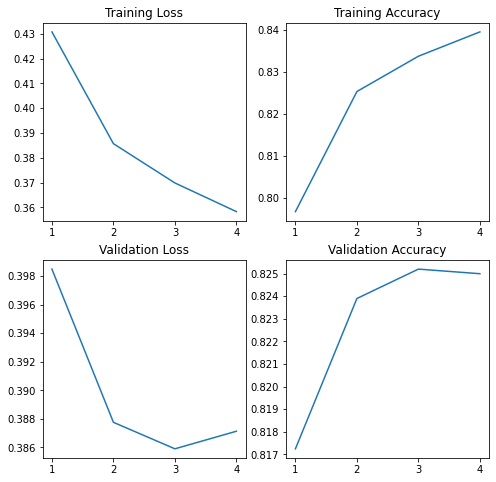

In [ ]:
history = history.history
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, 5), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, 5), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, 5), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, 5), history['val_accuracy'])

4761/4761 [==============================] - 31s 7ms/step - loss: 0.3851 - accuracy: 0.8274
Test Loss =  0.3850845396518707
Test Accuracy =  0.8274146318435669


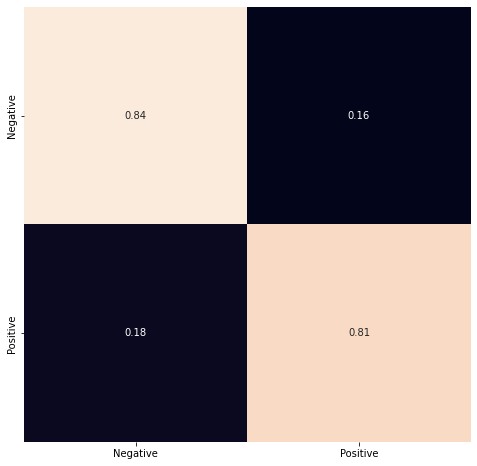

In [ ]:
[test_loss, test_accuracy] = model.evaluate(adjusted_X_test, adjusted_Y_test_one_hot)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)
predicted_Y_test = model.predict(adjusted_X_test)
confusion_matrix = tf.math.confusion_matrix(adjusted_Y_test, np.argmax(predicted_Y_test, axis=-1), 2).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.figure(figsize=(8, 8))
sn.heatmap(df, annot=True, cbar=False)

The performance of Pyramid LSTM is alomst equal to the One Sided LSTM and the Bidirectional LSTM, But its trainging time and convergence speed are worse than them.

# BERT

In [ ]:
adjusted_text = []
sentiment = []
for tweet in cleaned_data:
  adjusted_text.append(' '.join(tweet.adjusted_text))
  sentiment.append(int(tweet.sentiment/4))
sentiment = np.array(sentiment)[..., np.newaxis]

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/adjusted_text.pkl', 'wb') as f:
  pickle.dump(adjusted_text, f)
with open('/content/drive/MyDrive/DL - HW3 Practical/sentiment.pkl', 'wb') as f:
  pickle.dump(sentiment, f)

In [5]:
with open('/content/drive/MyDrive/DL - HW3 Practical/adjusted_text.pkl', 'rb') as f:
  adjusted_text = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/sentiment.pkl', 'rb') as f:
  sentiment = pickle.load(f)

In [6]:
random_number = np.random.randint(1e9)
np.random.seed(random_number)
permutation = np.random.choice(range(len(adjusted_text)), len(adjusted_text), False)
adjusted_text = [adjusted_text[i] for i in permutation]
sentiment = sentiment[permutation]
X_train = adjusted_text[0:int(5/10*len(adjusted_text))]
Y_train = sentiment[0:int(5/10*len(adjusted_text))]
X_validation = adjusted_text[int(5/10*len(adjusted_text)):int(51/100*len(adjusted_text))]
Y_validation = sentiment[int(5/10*len(adjusted_text)):int(51/100*len(adjusted_text))]
X_test = adjusted_text[int(99/100*len(adjusted_text)):len(adjusted_text)]
Y_test = sentiment[int(99/100*len(adjusted_text)):len(adjusted_text)]

In [7]:
Y_train_one_hot = tf.one_hot(Y_train[:, 0], 2)
Y_validation_one_hot = tf.one_hot(Y_validation[:, 0], 2)
Y_test_one_hot = tf.one_hot(Y_test[:, 0], 2)

In [9]:
BertLayer = tensorflow_hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2', trainable=True)

In [10]:
tokenizer = tokenization.FullTokenizer(BertLayer.resolved_object.vocab_file.asset_path.numpy(), BertLayer.resolved_object.do_lower_case.numpy())

In [11]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [12]:
bert_data_X_train = tf.ragged.constant([encode_sentence(s, tokenizer) for s in X_train])
cls_train = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*len(X_train)
bert_data_X_validation = tf.ragged.constant([encode_sentence(s, tokenizer) for s in X_validation])
cls_validation = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*len(X_validation)
bert_data_X_test = tf.ragged.constant([encode_sentence(s, tokenizer) for s in X_test])
cls_test = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*len(X_test)

In [25]:
length = 25
input_word_ids_train = tf.concat([cls_train, bert_data_X_train], axis=-1)
input_mask_train = tf.ones_like(input_word_ids_train).to_tensor(shape=(None, length))
input_type_ids_train = tf.concat([tf.zeros_like(cls_train), tf.zeros_like(bert_data_X_train)], axis=-1).to_tensor(shape=(None, length))
inputs_train = {'input_word_ids': input_word_ids_train.to_tensor(shape=(None, length)), 'input_mask': input_mask_train, 'input_type_ids': input_type_ids_train}
input_word_ids_validation = tf.concat([cls_validation, bert_data_X_validation], axis=-1)
input_mask_validation = tf.ones_like(input_word_ids_validation).to_tensor(shape=(None, length))
input_type_ids_validation = tf.concat([tf.zeros_like(cls_validation), tf.zeros_like(bert_data_X_validation)], axis=-1).to_tensor(shape=(None, length))
inputs_validation = {'input_word_ids': input_word_ids_validation.to_tensor(shape=(None, length)), 'input_mask': input_mask_validation, 'input_type_ids': input_type_ids_validation}
input_word_ids_test = tf.concat([cls_test, bert_data_X_test], axis=-1)
input_mask_test = tf.ones_like(input_word_ids_test).to_tensor(shape=(None, length))
input_type_ids_test = tf.concat([tf.zeros_like(cls_test), tf.zeros_like(bert_data_X_test)], axis=-1).to_tensor(shape=(None, length))
inputs_test = {'input_word_ids': input_word_ids_test.to_tensor(shape=(None, length)), 'input_mask': input_mask_test, 'input_type_ids': input_type_ids_test}

In [34]:
hidden_layer_size = 50
output_size = 2
batch_size = 256
number_of_epochs = 1

In [35]:
input_word_ids = tf.keras.layers.Input(shape=(length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(shape=(length,), dtype=tf.int32, name='input_mask')
input_type_ids = tf.keras.layers.Input(shape=(length,), dtype=tf.int32, name='input_type_ids')
pooled_output, sequence_output = BertLayer([input_word_ids, input_mask, input_type_ids])
fc = tf.keras.layers.Dense(hidden_layer_size, activation='ReLU', name='FC')(pooled_output)
output = tf.keras.layers.Dense(output_size, activation='softmax', name='output')(fc)
model = tf.keras.Model(inputs={'input_word_ids': input_word_ids, 'input_mask': input_mask, 'input_type_ids': input_type_ids}, outputs=output, name='BERT')
model.summary()

Model: "BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 25)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 25)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        108310273   ['input_word_ids[0][0]',         
                                 (None, 25, 768)]                 'input_mask[0][0]',          

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

In [37]:
def scheduler(epoch, lr):
  return lr/1.05
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(inputs_train, Y_train_one_hot, batch_size=batch_size, epochs=number_of_epochs, callbacks=[lr_cb], validation_data=(inputs_validation, Y_validation_one_hot))

2976/2976 [==============================] - 3556s 1s/step - loss: 0.3905 - accuracy: 0.8237 - val_loss: 0.3714 - val_accuracy: 0.8369 - lr: 9.5238e-05


Increasing the number of epochs is not practical because of the limited computational power on Google Colab (It took one hour only for one epoch). But the model accuracy is better than other models.

477/477 [==============================] - 27s 56ms/step - loss: 0.3742 - accuracy: 0.8338
Test Loss =  0.3742188811302185
Test Accuracy =  0.8338037133216858


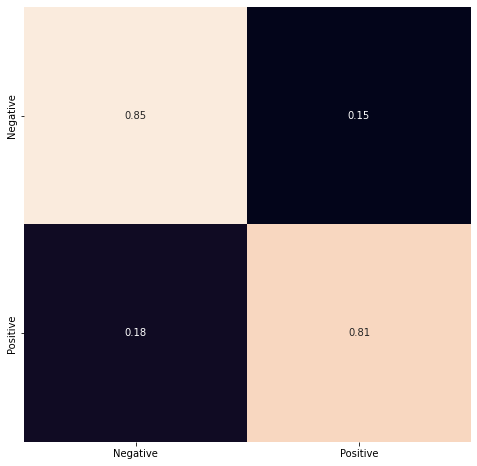

In [47]:
[test_loss, test_accuracy] = model.evaluate(inputs_test, Y_test_one_hot)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)
predicted_Y_test = model.predict(inputs_test)
confusion_matrix = tf.math.confusion_matrix(Y_test, np.argmax(predicted_Y_test, axis=-1), 2).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.figure(figsize=(8, 8))
sn.heatmap(df, annot=True, cbar=False)

# Final Comparison

It is evident from the above results that the results of all networks are good on training, validation, and test data and similar to each other. Best result was for BERT with a little difference. <br>
Comparing the models' parameters, One-Sided LSTM contains about 300,000 trainable parameters, half of the Bidirectional LSTM. But the pyramidal LSTM contains about 3M parameters, and Bert has 108M! This difference in the number of the model's parameters shows itself in the time consumed by the network for learning the problem.